# New Student Smart Replay Small Maze Experiments in Curriculum Learning

-------------------------------


Salkey, Jayson

26/07/2018

-----------------------------------


# Setup

### Import Useful Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from collections import namedtuple
from scipy import stats

### Set options

In [0]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=1)

In [0]:
class Maze(object):
    def __init__(self, width, height, complexity, density, num_goals, goal):
        self._maze, self._maze_clean, self._goal_locations = self.maze(width, height, complexity, density, num_goals, goal)
        
    def maze(self, width=81, height=51, complexity=.75, density=.75, num_goals=1, goal=1):
        goal_locations = []
        
        # Only odd shapes
        shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
        # Adjust complexity and density relative to maze size
        complexity = int(complexity * (5 * (shape[0] + shape[1]))) # number of components
        density    = int(density * ((shape[0] // 2) * (shape[1] // 2))) # size of components
        # Build actual maze
        Z = np.zeros(shape)
        # Fill borders
        Z[0, :] = Z[-1, :] = 1
        Z[:, 0] = Z[:, -1] = 1
        # Make aisles
        for i in range(density):
            x, y = np.random.randint(0, (shape[1] // 2)+1) * 2, np.random.randint(0, (shape[0] // 2)+1) * 2 # pick a random position
            Z[y, x] = 1
            for j in range(complexity):
                neighbours = []
                if x > 1:             neighbours.append((y, x - 2))
                if x < shape[1] - 2:  neighbours.append((y, x + 2))
                if y > 1:             neighbours.append((y - 2, x))
                if y < shape[0] - 2:  neighbours.append((y + 2, x))
                if len(neighbours):
                    y_,x_ = neighbours[np.random.randint(0, len(neighbours))]
                    if Z[y_, x_] == 0:
                        Z[y_, x_] = 1
                        Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                        x, y = x_, y_
        Z[Z == 1] = -1
        Y = np.copy(Z)
        for x in range(0, num_goals):
            idx = np.random.randint(len(np.where(Z == 0)[0]))
            Z[np.where(Z == 0)[0][idx],np.where(Z == 0)[1][idx]] = goal
        for e in zip(np.where(Z == goal)[0],np.where(Z == goal)[1]):
            goal_locations.append((e[0],e[1],goal))
        return Z,Y,goal_locations


### A hallway world

In [0]:
class Hallway(object):

  def __init__(self, goal_loc, tabular=True, vision_size=1, discount=0.98, noisy=False, layout=None):
    # 10: Key
    # -2: Door
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    
    self._wall = -1
    self._door = -2
    self._key = 10
    
    
#     self._layout = np.array([
#         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
#         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       ])
    if layout.all() != None:
        self._layout = layout
    else:
        self._layout = np.array([
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
              [-1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
              [-1,  0,  0, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1],
              [-1,  0,  0, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1],
              [-1,  0,  0, -1,  0,  0, -1, -1, -1, -1,  0,  0, -1,  0,  0, -1, -1],
              [-1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1, -1],
              [-1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1, -1],
              [-1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1],
              [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
              [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            ])
    
    
    self._goals = set()
    self._goal_loc = []
    
    for e in goal_loc:
      #print(self._layout.shape)
      #print(e)
      self._layout[e[0],e[1]] = e[2]
      self._goal_loc.append((e[0],e[1]))
      self._goals.add(e[2])
    
    #self._goal = value
    
    # row, col format
#     self._start_state = (12, 8)
    self._start_state = (1, 1)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size
    self._discount = discount
    self._distanceToGoal = None
    
    self._minDistanceStartGoal = self.minDistanceTwoPoints(self._start_state[0], self._start_state[1],
                                                          self._goal_loc[-1][0], self._goal_loc[-1][1])
    
    #self.distanceToGoal()
  def resetState(self):
    self._state = self._start_state
  
  def distanceToGoal(self):
    #return np.prod(self._layout.shape) if len(self._goal_loc) > 1 else self._minDistanceStartGoal
    #return np.count_nonzero(self._layout != self._wall)
    #return np.sum(self._layout.shape)
    return np.prod(self._layout.shape)
    
  def minDistanceTwoPoints(self, cy, cx, dy, dx):
    distances = []
    stack = []
    visited = set()
    stack.append((cy, cx, 0))
    while len(stack) != 0:
      #print len(stack)
      cur_row, cur_col, dist = stack.pop()
      if (cur_row, cur_col) in visited:
        continue
      visited.add((cur_row, cur_col))
      
      if (cur_row, cur_col) == (dy, dx):
        distances.append(dist)

      if cur_row+1 < self._layout.shape[0] and self._layout[cur_row+1, cur_col] != self._wall:
        stack.append((cur_row+1, cur_col, dist+1))
      if cur_row-1 > -1 and self._layout[cur_row-1, cur_col] != self._wall:
        stack.append((cur_row-1, cur_col, dist+1))
      if cur_col+1 < self._layout.shape[1] and self._layout[cur_row, cur_col+1] != self._wall:
        stack.append((cur_row, cur_col+1, dist+1))
      if cur_col-1 > -1 and self._layout[cur_row, cur_col-1] != self._wall:
        stack.append((cur_row, cur_col-1, dist+1))
    
    return np.min(np.array(distances))
  
  def distanceToNearestGoal(self, new_y, new_x):
    distances = []
    locations = []
    stack = []
    visited = set()
    stack.append((new_y, new_x, 0))
    while len(stack) != 0:
      #print len(stack)
      cur_row, cur_col, dist = stack.pop()
      if (cur_row, cur_col) in visited:
        continue
      visited.add((cur_row, cur_col))
      
      for e in self._goal_loc:
        if (cur_row, cur_col) == e:
          distances.append(dist)
          locations.append(e)
          

      if cur_row+1 < self._layout.shape[0] and self._layout[cur_row+1, cur_col] != self._wall:
        stack.append((cur_row+1, cur_col, dist+1))
      if cur_row-1 > -1 and self._layout[cur_row-1, cur_col] != self._wall:
        stack.append((cur_row-1, cur_col, dist+1))
      if cur_col+1 < self._layout.shape[1] and self._layout[cur_row, cur_col+1] != self._wall:
        stack.append((cur_row, cur_col+1, dist+1))
      if cur_col-1 > -1 and self._layout[cur_row, cur_col-1] != self._wall:
        stack.append((cur_row, cur_col-1, dist+1))
    
    # Has to be the absolute closest person
    argmin_dist = np.argmin(np.array(distances))
    #print(distances[argmin_dist], locations[argmin_dist])
    return distances[argmin_dist], locations[argmin_dist] 
    
  def handleDoor(self):
    pass
  
  @property
  def number_of_states(self):
    return self._number_of_states
    
  def plot_grid(self, title=None):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != self._wall, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    
    if title != None:
      plt.title(title)
    else:
      plt.title("The Grid")
    plt.text(self._start_state[1], self._start_state[0], r"$\mathbf{S}$", ha='center', va='center')
    
    for e in self._goals:
      if e == self._key:
        y = np.where(self._layout==e)[0]
        x = np.where(self._layout==e)[1]
        for i in range(y.shape[0]): 
          plt.text(x[i], y[i], r"$\mathbf{K}$", ha='center', va='center')
      elif e > 0:
        y = np.where(self._layout==e)[0]
        x = np.where(self._layout==e)[1]
        for i in range(y.shape[0]): 
          plt.text(x[i], y[i], r"$\mathbf{G}$", ha='center', va='center')
    y = np.where(self._layout==self._door)[0]
    x = np.where(self._layout==self._door)[1]
    for i in range(y.shape[0]): 
      plt.text(x[i], y[i], r"$\mathbf{D}$", ha='center', va='center')
    
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      #location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      #location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], -1, 2)
      location = self._layout[y-v:y+v+1,x-v:x+v+1]
      return location

  def step(self, action, agent_inventory):
    item = None
    y, x = self._state
        
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = self._discount
    if self._layout[new_y, new_x] == self._wall:  # a wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] == self._key: # a key
      reward = self._layout[new_y, new_x]
      item = 'KEY'
      discount = 0.
      new_state = self._start_state
      print('PICKED UP KEY')
    elif self._layout[new_y, new_x] == self._door: # a door
      reward = 5
      if 'KEY' not in agent_inventory:
        reward = self._layout[new_y, new_x]
        new_state = (y, x)
    elif self._layout[new_y, new_x] > 0: # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      
#       reward = 0.
      distToNearestGoal, nearestGoal = self.distanceToNearestGoal(new_y, new_x)
      distToNearestGoal = float(distToNearestGoal)
      
      #print(self._layout[nearestGoal[0],nearestGoal[1]], distToNearestGoal, minDistance, distToNearestGoal/minDistance, -distToNearestGoal/minDistance, np.exp(-distToNearestGoal/minDistance))
      reward = self._layout[nearestGoal[0],nearestGoal[1]]*np.exp(-distToNearestGoal)
      if self._layout[nearestGoal[0],nearestGoal[1]] == 100 and 'KEY' not in agent_inventory:
        reward = 0.
#       elif self._layout[nearestGoal[0],nearestGoal[1]] == 100 and 'KEY' in agent_inventory:
#         print agent_inventory
        
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs(), item
     

### The Hallway(s)

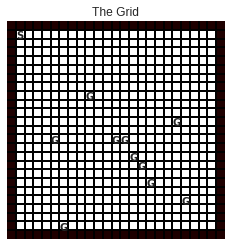

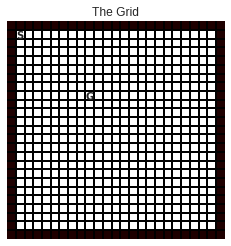

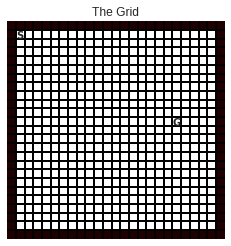

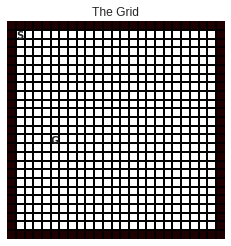

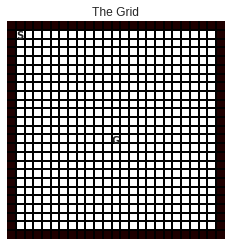

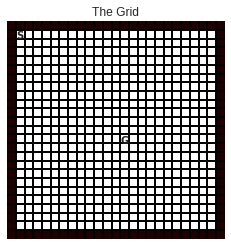

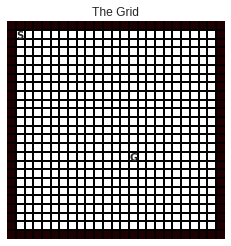

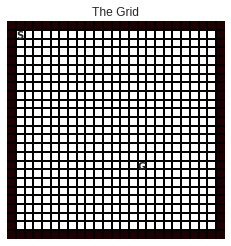

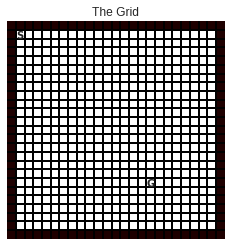

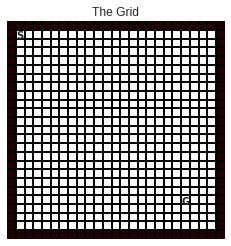

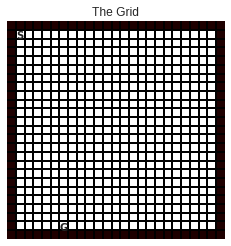

In [77]:
# tempHallway = Hallway(goal_loc=[(1,1,1)], discount=0.98)

# tasks = []

# for x in range(0,tempHallway._layout.shape[1]-2,12):
#   tasks.append(Hallway(goal_loc=[(r,x+1,1) for r in range(1,tempHallway._layout.shape[0]-1,2)], discount=0.98))
# del tasks[0]
# del tempHallway

# for idt,task in enumerate(tasks):
#   task.plot_grid(title="grid_{}".format(idt) )
  
maze = Maze(25,25,0.,0.,10,101)
  
tasks = []
tasks.append(Hallway(goal_loc = maze._goal_locations, discount=0.98, layout=np.copy(maze._maze_clean)))
for goal in maze._goal_locations:
    tasks.append(Hallway(goal_loc = [goal], discount=0.98, layout=np.copy(maze._maze_clean)))


for task in tasks:
    task.plot_grid()


## Implement agents


In [0]:
class NEURAL_TEACHER_STUDENT(object):
  
  # Target Network is the same, as C-step is just C=1
  
  def __init__(self, number_of_features_teacher,
                number_of_features_student,
                number_of_features_substitute,
                number_of_hidden_teacher,
                number_of_hidden_student,
                number_of_hidden_substitute,
                number_of_actions_teacher,
                number_of_actions_student,
                number_of_actions_substitute,
                initial_state_teacher,
                initial_state_student, 
                initial_state_substitute,
                rl_alg_teacher='DQN',
                rl_alg_student='DQN', 
                rl_alg_substitute='DQN',
                num_offline_updates_teacher=20, 
                num_offline_updates_student=25,
                num_offline_updates_substitute=25,
                step_size_teacher=0.01,
                step_size_student=0.01,
                step_size_substitute=0.01): 
    # HMMM?
    tf.reset_default_graph()

    self._prev_action_student = 0
    self._step_student = step_size_student
    self._num_features_student = number_of_features_student
    self._num_action_student = number_of_actions_student
    self._num_hidden_student = number_of_hidden_student
    self._initial_state_student = initial_state_student
    self._s_student = initial_state_student
    self._s_student = np.reshape(self._s_student, (1,-1))
    self._times_trained_student = 0
    self._inventory_student = set()
    self._replayBuffer_student = []
    self._num_offline_updates_student = num_offline_updates_student
    self._rl_alg_student = rl_alg_student


    self._prev_action_substitute = 0
    self._step_substitute = step_size_substitute
    self._num_features_substitute = number_of_features_substitute
    self._num_action_substitute = number_of_actions_substitute
    self._num_hidden_substitute = number_of_hidden_substitute
    self._initial_state_substitute = initial_state_substitute
    self._s_substitute = initial_state_substitute
    self._s_substitute = np.reshape(self._s_substitute, (1,-1))
    self._times_trained_substitute = 0
    self._inventory_substitute = set()
    self._replayBuffer_substitute = []
    self._num_offline_updates_substitute = num_offline_updates_substitute
    self._rl_alg_substitute = rl_alg_substitute

    
    self._prev_action_teacher = 0
    self._step_teacher = step_size_teacher
    self._num_features_teacher = number_of_features_teacher
    self._num_action_teacher = number_of_actions_teacher
    self._num_hidden_teacher = number_of_hidden_teacher
    self._initial_state_teacher = initial_state_teacher
    self._s_teacher = initial_state_teacher
    self._s_teacher = np.reshape(self._s_teacher, (1,-1))
    self._times_trained_teacher = 0
    self._replayBuffer_teacher = []
    self._num_offline_updates_teacher = num_offline_updates_teacher
    self._rl_alg_teacher = rl_alg_teacher
    self.name = 'HYPER '+self._rl_alg_teacher
  
    # ?????????? should it be the number of tasks
    self._probs_teacher = np.ones((1, self._num_features_teacher))/(self._num_features_teacher*1.)
    
    
    self._times_used = 0.
    
    self.handleTF()
  
  def reset(self):
    tf.reset_default_graph()
    self.handleTF()
    self.resetState_teacher()
    self.resetReplayBuffer_teacher()
    self._probs_teacher = np.ones((1, self._num_features_teacher))/(self._num_features_teacher*1.)
    self._times_trained_teacher = 0
    self._prev_action_teacher = 0

    self.resetReplayBuffer('TRAIN_STUDENT')
    self.resetState('TRAIN_STUDENT')
    self._times_trained_student = 0
    self._prev_action_student = 0
    self._inventory_student = set()

    self.resetReplayBuffer('TEST_SUBSTITUTE')
    self.resetState('TEST_SUBSTITUTE')
    self._times_trained_substitute = 0
    self._prev_action_substitute = 0
    self._inventory_substitute = set()

    self._times_used = 0



  def resetReplayBuffer_teacher(self):
    self._replayBuffer_teacher = []
    
  def resetState_teacher(self):
    self._s_teacher = self._initial_state_teacher 
    self._s_teacher = np.reshape(self._s_teacher, (1,-1))
    
  def handleTF(self):
    self._sess = tf.Session()
    #tf.reset_default_graph()
    self.rewTensor_teacher = tf.placeholder(tf.float64)
    self.disTensor_teacher = tf.placeholder(tf.float64)
    self.nqTensor_teacher = tf.placeholder(tf.float64)
    self.actionTensor_teacher = tf.placeholder(tf.int32)
    self.stateTensor_teacher = tf.placeholder(tf.float64, shape=(1,self._num_features_teacher))
    self._dense_1_teacher = tf.layers.dense(self.stateTensor_teacher,
                                    self._num_hidden_teacher, activation=tf.nn.relu,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2_teacher = tf.layers.dense(self._dense_1_teacher,
                                    self._num_action_teacher, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q_teacher = tf.reshape(self._dense_2_teacher, (self._num_action_teacher,))    
    self._softmx_teacher = tf.nn.softmax(self._q_teacher)
    self._cost_teacher = tf.losses.mean_squared_error(self.rewTensor_teacher + self.disTensor_teacher*self.nqTensor_teacher, self._q_teacher[self.actionTensor_teacher])
    self._opt_teacher = tf.train.RMSPropOptimizer(self._step_teacher).minimize(self._cost_teacher) 
    

    self.rewTensor_student = tf.placeholder(tf.float64)
    self.disTensor_student = tf.placeholder(tf.float64)
    self.nqTensor_student = tf.placeholder(tf.float64)
    self.actionTensor_student = tf.placeholder(tf.int32)
    self.stateTensor_student = tf.placeholder(tf.float64, shape=(1,self._num_features_student))
    self._dense_1_student = tf.layers.dense(self.stateTensor_student,
                                    self._num_hidden_student, activation=tf.nn.relu,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2_student = tf.layers.dense(self._dense_1_student,
                                    self._num_action_student, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q_student = tf.reshape(self._dense_2_student, (self._num_action_student,))    
    self._cost_student = tf.losses.mean_squared_error(self.rewTensor_student+ self.disTensor_student*self.nqTensor_student, self._q_student[self.actionTensor_student])
    self._opt_student = tf.train.RMSPropOptimizer(self._step_student).minimize(self._cost_student)


    self.rewTensor_substitute = tf.placeholder(tf.float64)
    self.disTensor_substitute = tf.placeholder(tf.float64)
    self.nqTensor_substitute = tf.placeholder(tf.float64)
    self.actionTensor_substitute = tf.placeholder(tf.int32)
    self.stateTensor_substitute = tf.placeholder(tf.float64, shape=(1,self._num_features_substitute))
    self._dense_0_substitute = tf.layers.dense(self.stateTensor_substitute,
                                    self._num_hidden_substitute, activation=tf.nn.relu,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_1_substitute = tf.layers.dense(self._dense_0_substitute,
                                    self._num_hidden_substitute, activation=tf.nn.relu,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2_substitute = tf.layers.dense(self._dense_1_substitute,
                                    self._num_action_substitute, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q_substitute = tf.reshape(self._dense_2_substitute, (self._num_action_substitute,))    
    self._cost_substitute = tf.losses.mean_squared_error(self.rewTensor_substitute+ self.disTensor_substitute*self.nqTensor_substitute, self._q_substitute[self.actionTensor_substitute])
    self._opt_substitute = tf.train.RMSPropOptimizer(self._step_substitute).minimize(self._cost_substitute)
    
    # HMMM?
    self._sess.run(tf.global_variables_initializer())

  def _target_policy_teacher(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy_teacher(self, q):    
    return epsilon_greedy(q, 0.1)# if train == True else np.random.choice(np.where(np.max(q) == q)[0])

  def getProbs(self):
    # softmax
    return self._probs_teacher

  def q_teacher(self, obs):
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]
    obs = np.reshape(obs,(1,-1))
    #print obs
    t, probs = self._sess.run([self._q_teacher, self._softmx_teacher], {self.stateTensor_teacher: obs})
    return t, probs
  
  def step_teacher(self, r, g, s, train):
    self._times_used += 1
    #print self._times_used
    qvs, probs = self.q_teacher(s)
    q_nxtState = np.reshape(qvs, (-1,))
    self._probs_teacher = probs
    next_action = self._behaviour_policy_teacher(q_nxtState)
    
    if r != None and train == True:
      if self._rl_alg_teacher == 'NEURALSARSA':
        target = self._target_policy_teacher(q_nxtState, next_action)
        target = np.random.choice(np.where(np.max(target) == target)[0])
        vob = q_nxtState[target]
        #print vob
        self._sess.run(self._opt_teacher,{
            self.nqTensor_teacher: vob,
            self.rewTensor_teacher: r,
            self.disTensor_teacher: g,
            self.actionTensor_teacher: self._prev_action_teacher,
            self.stateTensor_teacher: self._s_teacher})
        self._replayBuffer_teacher.append([self._s_teacher, self._prev_action_teacher, r, g, vob])
        for _ in range(self._num_offline_updates_teacher):
          replay = self._replayBuffer_teacher[np.random.randint(len(self._replayBuffer_teacher))]
          self._sess.run(self._opt_teacher,{
              self.nqTensor_teacher: replay[4],
              self.rewTensor_teacher: replay[2],
              self.disTensor_teacher: replay[3],
              self.actionTensor_teacher: replay[1],
              self.stateTensor_teacher: replay[0]})
      elif self._rl_alg_teacher == 'DQN':
        # This function should return an action
        # Optimiser
        vob = np.max(q_nxtState)
        self._sess.run(self._opt_teacher,{
            self.nqTensor_teacher: vob,
            self.rewTensor_teacher: r,
            self.disTensor_teacher: g,
            self.actionTensor_teacher: self._prev_action_teacher,
            self.stateTensor_teacher: self._s_teacher})
        self._replayBuffer_teacher.append([self._s_teacher, self._prev_action_teacher, r, g, vob])
        for _ in range(self._num_offline_updates_teacher):
          replay = self._replayBuffer_teacher[np.random.randint(len(self._replayBuffer_teacher))]
          self._sess.run(self._opt_teacher,{
              self.nqTensor_teacher: replay[4],
              self.rewTensor_teacher: replay[2],
              self.disTensor_teacher: replay[3],
              self.actionTensor_teacher: replay[1],
              self.stateTensor_teacher: replay[0]})

    self._s_teacher = np.reshape(s, (1,-1))
    self._prev_action_teacher = next_action
    
    return next_action

  def reset_teacher(self):
    tf.reset_default_graph()
    self.handleTF()
    self.resetState_teacher()
    self.resetReplayBuffer_teacher()
    self._probs_teacher = np.ones((1, self._num_features_teacher))/(self._num_features_teacher*1.)
    self._times_trained_teacher = 0
    self._prev_action_teacher = 0



    # resetReplayBuffer_student
  def resetReplayBuffer(self, STUDENT_TYPE):
    if STUDENT_TYPE == 'TRAIN_STUDENT':
      self._replayBuffer_student = []
    elif STUDENT_TYPE == 'TEST_SUBSTITUTE':
      self._replayBuffer_substitute = []

    # resetState_student
  def resetState(self, STUDENT_TYPE):
    if STUDENT_TYPE == 'TRAIN_STUDENT':
      self._s_student = self._initial_state_student 
      self._s_student = np.reshape(self._s_student, (1,-1))
    elif STUDENT_TYPE == 'TEST_SUBSTITUTE':
      self._s_substitute = self._initial_state_substitute
      self._s_substitute = np.reshape(self._s_substitute, (1,-1))


  def _target_policy_student(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy_student(self, q, train):
    #return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])
    return epsilon_greedy(q, 0.1) if train == True else epsilon_greedy(q, 0.05)

  def _target_policy_substitute(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy_substitute(self, q, train):
    #return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])
    return epsilon_greedy(q, 0.1) if train == True else epsilon_greedy(q, 0.05)
  
  def q_student(self, obs):
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]
    obs = np.reshape(obs,(1,-1))
    #print obs
    t = self._sess.run(self._q_student, {self.stateTensor_student: obs})
    return t
  
  def q_substitute(self, obs):
    obs = np.reshape(obs, (1,-1))
    t = self._sess.run(self._q_substitute, {self.stateTensor_substitute: obs})
    return t

  # step_student
  def step(self, r, g, s, item, train, STUDENT_TYPE):
    cost = None
    
    if STUDENT_TYPE == 'TRAIN_STUDENT':
      if item != None:
        self._inventory_student.add(item)
      
      # This function should return an action
      q_nxtState = np.reshape(self.q_student(s), (-1,))
      next_action = self._behaviour_policy_student(q_nxtState, train)
      

      if self._rl_alg_student == 'NEURALSARSA':
        target = self._target_policy_student(q_nxtState, next_action)
        target = np.random.choice(np.where(np.max(target) == target)[0])
        
        # Optimiser
        vob = q_nxtState[target]
        if train == True:
          self._sess.run(self._opt_student,{
              self.nqTensor_student: vob,
              self.rewTensor_student: r,
              self.disTensor_student: g,
              self.actionTensor_student: self._prev_action_student,
              self.stateTensor_student: self._s_student})
          self._replayBuffer_student.append([self._s_student, self._prev_action_student, r, g, vob])
          for _ in range(self._num_offline_updates_student):
            replay = self._replayBuffer_student[np.random.randint(len(self._replayBuffer_student))]
            self._sess.run(self._opt_student,{
                self.nqTensor_student: replay[4],
                self.rewTensor_student: replay[2],
                self.disTensor_student: replay[3],
                self.actionTensor_student: replay[1],
                self.stateTensor_student: replay[0]})
      elif self._rl_alg_student == 'DQN':
        vob = np.max(q_nxtState)
        if train == True:
          self._sess.run(self._opt_student,{
              self.nqTensor_student: vob,
              self.rewTensor_student: r,
              self.disTensor_student: g,
              self.actionTensor_student: self._prev_action_student,
              self.stateTensor_student: self._s_student})
          self._replayBuffer_student.append([self._s_student, self._prev_action_student, r, g, vob])
          for _ in range(self._num_offline_updates_student):
            replay = self._replayBuffer_student[np.random.randint(len(self._replayBuffer_student))]
            self._sess.run(self._opt_student,{
                self.nqTensor_student: replay[4],
                self.rewTensor_student: replay[2],
                self.disTensor_student: replay[3],
                self.actionTensor_student: replay[1],
                self.stateTensor_student: replay[0]})

      
          
      self._s_student = np.reshape(s, (1,-1))
      self._prev_action_student = next_action
      return next_action, self._inventory_student, cost

    elif STUDENT_TYPE == 'TEST_SUBSTITUTE':
      if item != None:
        self._inventory_substitute.add(item)
      
      # This function should return an action
      q_nxtState = np.reshape(self.q_substitute(s), (-1,))
      next_action = self._behaviour_policy_substitute(q_nxtState, train)
      

      if self._rl_alg_substitute == 'NEURALSARSA':
        target = self._target_policy_substitute(q_nxtState, next_action)
        target = np.random.choice(np.where(np.max(target) == target)[0])
        
        # Optimiser
        vob = q_nxtState[target]

        if train == True:
          self._sess.run(self._opt_substitute,{
              self.nqTensor_substitute: vob,
              self.rewTensor_substitute: r,
              self.disTensor_substitute: g,
              self.actionTensor_substitute: self._prev_action_substitute,
              self.stateTensor_substitute: self._s_substitute})
          self._replayBuffer_substitute.append([self._s_substitute, self._prev_action_substitute, r, g, vob])
          for _ in range(self._num_offline_updates_substitute):
            replay = self._replayBuffer_substitute[np.random.randint(len(self._replayBuffer_substitute))]
            self._sess.run(self._opt_substitute,{
                self.nqTensor_substitute: replay[4],
                self.rewTensor_substitute: replay[2],
                self.disTensor_substitute: replay[3],
                self.actionTensor_substitute: replay[1],
                self.stateTensor_substitute: replay[0]})
      elif self._rl_alg_substitute == 'DQN':
        vob = np.max(q_nxtState)
        if train == True:
          self._sess.run(self._opt_substitute,{
              self.nqTensor_substitute: vob,
              self.rewTensor_substitute: r,
              self.disTensor_substitute: g,
              self.actionTensor_substitute: self._prev_action_substitute,
              self.stateTensor_substitute: self._s_substitute})
          self._replayBuffer_substitute.append([self._s_substitute, self._prev_action_substitute, r, g, vob])
          for _ in range(self._num_offline_updates_substitute):
            replay = self._replayBuffer_substitute[np.random.randint(len(self._replayBuffer_substitute))]
            self._sess.run(self._opt_substitute,{
                self.nqTensor_substitute: replay[4],
                self.rewTensor_substitute: replay[2],
                self.disTensor_substitute: replay[3],
                self.actionTensor_substitute: replay[1],
                self.stateTensor_substitute: replay[0]})
          
      self._s_substitute = np.reshape(s, (1,-1))
      self._prev_action_substitute = next_action
      return next_action, self._inventory_substitute, cost

## Task Selector

In [0]:
class TaskSelector(object):
  """An adversarial multi-armed Task bandit."""
  
  def __init__(self, rl_agent, tasks, reward_signal, number_of_tasks_selection_steps, student_type):
    self._unscaled_reward_history = []
    self._student_type = student_type
    self._rl_agent = rl_agent
    self._tasks = tasks
    self._reward_signal = reward_signal
    self._tasks_buffer = np.zeros((5,len(tasks)))
    self._tasks_buffer_scaled = np.zeros((5,len(tasks)))
    self._tasks_episodes_completed_train = np.zeros((len(tasks), number_of_tasks_selection_steps))
    self._tasks_episodes_completed_test = np.zeros((len(tasks), number_of_tasks_selection_steps))
    self._time = 0
    self._number_of_tasks_selection_steps = number_of_tasks_selection_steps
    
    self._train_tasks_times_selected = np.zeros((len(tasks)))
    self._test_tasks_times_selected = np.zeros((len(tasks)))
    self._train_task_accuracy = np.zeros((len(tasks), number_of_tasks_selection_steps))
    self._test_task_accuracy = np.zeros((len(tasks), number_of_tasks_selection_steps))
    
  def resetReplayBuffer(self):
    self._rl_agent.resetReplayBuffer(self._student_type)    
  
  def step(self, action_task_id):
    
    print('Selected Task: ', action_task_id)
    
    if self._reward_signal == 'SPG':
      self._train_tasks_times_selected[action_task_id] += 1.
      self._test_tasks_times_selected[action_task_id] += 1.
      
      _, _, ep_comp_train = run_step(self._tasks[action_task_id], self._rl_agent, True, self._student_type)
      reward_after, reward_steps_after, ep_comp_test = run_step(self._tasks[action_task_id], self._rl_agent, False, self._student_type)
      
      self._tasks_episodes_completed_train[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time-1]+1 if ep_comp_train == True else self._tasks_episodes_completed_train[action_task_id, self._time-1] 
      
      self._train_task_accuracy[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time] / self._train_tasks_times_selected[action_task_id]
      
      for x in range(self._tasks_episodes_completed_train.shape[0]):
        if x != action_task_id:
          self._tasks_episodes_completed_train[x, self._time] = self._tasks_episodes_completed_train[x, self._time-1]
          self._train_task_accuracy[x, self._time] = \
          self._tasks_episodes_completed_train[x, self._time] / self._train_tasks_times_selected[x]
      
      self._tasks_episodes_completed_test[action_task_id, self._time] = \
      self._tasks_episodes_completed_test[action_task_id, self._time-1]+1 if ep_comp_test == True else self._tasks_episodes_completed_test[action_task_id, self._time-1] 
      
      self._test_task_accuracy[action_task_id, self._time] = \
      self._tasks_episodes_completed_test[action_task_id, self._time] / self._test_tasks_times_selected[action_task_id]
   
      for x in range(self._tasks_episodes_completed_test.shape[0]):
        if x != action_task_id:
          self._tasks_episodes_completed_test[x, self._time] = self._tasks_episodes_completed_test[x, self._time-1]
          self._test_task_accuracy[x, self._time] = \
          self._tasks_episodes_completed_test[x, self._time] / self._test_tasks_times_selected[x]
       
    elif self._reward_signal == 'TPG':
      self._train_tasks_times_selected[action_task_id] += 1.
      self._test_tasks_times_selected[-1] += 1.
      
      _, _, ep_comp_train = run_step(self._tasks[action_task_id], self._rl_agent, True, self._student_type)
      reward_after, reward_steps_after, ep_comp_test = run_step(self._tasks[-1], self._rl_agent, False, self._student_type)
      
      self._tasks_episodes_completed_train[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time-1]+1 if ep_comp_train == True else self._tasks_episodes_completed_train[action_task_id, self._time-1] 
      
      self._train_task_accuracy[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time] / self._train_tasks_times_selected[action_task_id]
      
      for x in range(self._tasks_episodes_completed_train.shape[0]):
        if x != action_task_id:
          self._tasks_episodes_completed_train[x, self._time] = self._tasks_episodes_completed_train[x, self._time-1]
          self._train_task_accuracy[x, self._time] = \
          self._tasks_episodes_completed_train[x, self._time] / self._train_tasks_times_selected[x]
      
      self._tasks_episodes_completed_test[-1, self._time] = \
      self._tasks_episodes_completed_test[-1, self._time-1]+1 if ep_comp_test == True else self._tasks_episodes_completed_test[-1, self._time-1] 
      
      self._test_task_accuracy[-1, self._time] = \
      self._tasks_episodes_completed_test[-1, self._time] / self._test_tasks_times_selected[-1]
      
      for x in range(self._tasks_episodes_completed_test.shape[0]-1):
        self._tasks_episodes_completed_test[x, self._time] = self._tasks_episodes_completed_test[x, self._time-1]
        self._test_task_accuracy[x, self._time] = \
        self._tasks_episodes_completed_test[x, self._time] / self._test_tasks_times_selected[x]  
        
    
    elif self._reward_signal == 'MPG':
      uniform_sampled_task_id = np.random.choice(len(self._tasks))
      
      self._train_tasks_times_selected[action_task_id] += 1.
      self._test_tasks_times_selected[uniform_sampled_task_id] += 1.
      
      _, _, ep_comp_train = run_step(self._tasks[action_task_id], self._rl_agent, True, self._student_type)
      reward_after, reward_steps_after, ep_comp_test = run_step(self._tasks[uniform_sampled_task_id], self._rl_agent, False, self._student_type)
      
      self._tasks_episodes_completed_train[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time-1]+1 if ep_comp_train == True else self._tasks_episodes_completed_train[action_task_id, self._time-1] 
      
      self._train_task_accuracy[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time] / self._train_tasks_times_selected[action_task_id]
      
      for x in range(self._tasks_episodes_completed_train.shape[0]):
        if x != action_task_id:
          self._tasks_episodes_completed_train[x, self._time] = self._tasks_episodes_completed_train[x, self._time-1]
          self._train_task_accuracy[x, self._time] = \
          self._tasks_episodes_completed_train[x, self._time] / self._train_tasks_times_selected[x]
      
      
      self._tasks_episodes_completed_test[uniform_sampled_task_id, self._time] = \
      self._tasks_episodes_completed_test[uniform_sampled_task_id, self._time-1]+1 if ep_comp_test == True else self._tasks_episodes_completed_test[uniform_sampled_task_id, self._time-1] 
      
      self._test_task_accuracy[uniform_sampled_task_id, self._time] = \
      self._tasks_episodes_completed_test[uniform_sampled_task_id, self._time] / self._test_tasks_times_selected[uniform_sampled_task_id]
      
      for x in range(self._tasks_episodes_completed_test.shape[0]):
        if x != uniform_sampled_task_id:
          self._tasks_episodes_completed_test[x, self._time] = self._tasks_episodes_completed_test[x, self._time-1]
          self._test_task_accuracy[x, self._time] = \
          self._tasks_episodes_completed_test[x, self._time] / self._test_tasks_times_selected[x]     
    
    self._time += 1
    self._tasks_buffer[:,action_task_id] = np.roll(self._tasks_buffer[:,action_task_id], 1)
    self._tasks_buffer[0,action_task_id] = reward_after
    X = np.arange(self._tasks_buffer.shape[0])
    slope, _, _, _, _ = stats.linregress(X, self._tasks_buffer[:,action_task_id])
    rhat = slope 
    
#     for i in range(self._tasks_buffer.shape[1]):
#       slope, _, _, _, _ = stats.linregress(X, self._tasks_buffer[:,i])
#       print("Task: ", i, slope)
    
#     self._unscaled_reward_history.append(rhat)
#     temp_history = np.array(sorted(self._unscaled_reward_history))
#     p_20 = np.percentile(temp_history, 20)
#     p_80 = np.percentile(temp_history, 80)        

#     if action_task_id < 0 or action_task_id >= len(self._tasks):
#       raise ValueError('Action {} is out of bounds for a '
#                        '{}-armed bandit'.format(action_task_id, len(split_train_tasks)))
    
#     r = None
#     if rhat <= p_20:
#       r = -1.
#     elif rhat > p_80:
#       r = 1.
#     else:
#       r = 2.0 * (rhat - p_20)/(p_80 - p_20) - 1.
      
#     self._tasks_buffer_scaled[:,action_task_id] = np.roll(self._tasks_buffer_scaled[:,action_task_id], 1)
#     self._tasks_buffer_scaled[0,action_task_id] = r
    
    # Perhaps, plot the variance or something else, because the train==False fucks this plot up
    return rhat, reward_after, np.reshape(self._tasks_buffer.T,(-1,)), ep_comp_train

In [0]:
def plot_values(values, colormap='pink', vmin=None, vmax=None):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, title, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(24, 24))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  #print vmin, vmax
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title(r"$v(s), \mathrm{" + title + r"}$")
#   plt.savefig('./action_values_{}'.format(title))
#   plt.close()

def plot_greedy_policy(grid, title, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid(title)
  plt.hold('on')
  for i in range(grid._layout.shape[0]):
    for j in range(grid._layout.shape[1]):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

In [0]:
def plot_task_accuracy(accuracy_train, accuracy_test, student, teacher, reward_signal):
  
  plt.figure(figsize=(12,12))
  plt.title('Average Accuracy of Train Episodes; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Accuracy')
  plt.xlabel('Time')
  for x in range(accuracy_train.shape[0]):    
    plot = plt.plot(accuracy_train[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
  
  plt.figure(figsize=(12,12))
  plt.title('Average Accuracy of Test Episodes; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Accuracy')
  plt.xlabel('Time')
  for x in range(accuracy_test.shape[0]):    
    plot = plt.plot(accuracy_test[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')

In [0]:
def plot_completed_episodes(completed_train, completed_test, student, teacher, reward_signal):
  
  plt.figure(figsize=(12,12))
  plt.title('Cumulative Average Number of Train Episodes Completed; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Episodes Completed')
  plt.xlabel('Time')
  for x in range(completed_train.shape[0]):    
    plot = plt.plot(completed_train[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
  
  plt.figure(figsize=(12,12))
  plt.title('Cumulative Average Number of Test Episodes Completed; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Episodes Completed')
  plt.xlabel('Time')
  for x in range(completed_test.shape[0]):    
    plot = plt.plot(completed_test[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')

In [0]:
def run_experiment(bandit, algs, tasks, number_of_steps_of_selecting_tasks, repetitions, vision_size, tabular, agent_type_driver, hidden_units, step_size, reward_signal):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  reward_delta_dict = {}
  action_dict = {}
  prob_dict = {}
  entropy_dict = {}
  
  student_type = ['TRAIN_STUDENT', 'TEST_SUBSTITUTE']
  alg = algs[0]
  
  for typ in student_type:
    print('Running:', alg.name + ' ' + typ)
    reward_dict[alg.name + ' ' + typ] = []
    reward_delta_dict[alg.name + ' ' + typ] = []
    action_dict[alg.name + ' ' + typ] = []
    prob_dict[alg.name + ' ' + typ] = []
    entropy_dict[alg.name + ' ' + typ] = []
    
    qs = None
    completed_train_episodes = np.zeros((len(tasks),number_of_steps_of_selecting_tasks))
    completed_test_episodes = np.zeros((len(tasks),number_of_steps_of_selecting_tasks))
    train_task_accuracy = np.zeros((len(tasks),number_of_steps_of_selecting_tasks))
    test_task_accuracy = np.zeros((len(tasks),number_of_steps_of_selecting_tasks)) 
      
#     alg.reset()
    bandit = TaskSelector(alg, tasks, reward_signal, number_of_steps_of_selecting_tasks, typ)

    reward_dict[alg.name + ' ' + typ].append([0.])
    reward_delta_dict[alg.name + ' ' + typ].append([])
    action_dict[alg.name + ' ' + typ].append([])
    prob_dict[alg.name + ' ' + typ].append([])
    entropy_dict[alg.name + ' ' + typ].append([])
    action = None
    reward = None
    prob = None
    entropy = None
    reward_delta = None
    success_student_episode = False
    capability = alg._initial_state_teacher

    for i in range(number_of_steps_of_selecting_tasks):
      print('Step: ', i)
      if typ == 'TRAIN_STUDENT':
        action = alg.step_teacher(reward, 0., capability, True) if success_student_episode == True else alg.step_teacher(reward, 0.98, capability, True)
      elif typ == 'TEST_SUBSTITUTE':
        action = alg.step_teacher(reward, 0., capability, False) if success_student_episode == True else alg.step_teacher(reward, 0.98, capability, False)
      prob = alg.getProbs()
      entropy = -1.0 * np.sum(prob * np.log(prob))
      reward, reward_from_environment, capability, success_student_episode = bandit.step(action)
      bandit.resetReplayBuffer()
      
      reward_dict[alg.name + ' ' + typ][-1].append(reward_from_environment+reward_dict[alg.name + ' ' + typ][-1][-1])
      reward_delta_dict[alg.name + ' ' + typ][-1].append(reward)
      action_dict[alg.name + ' ' + typ][-1].append(action)
      prob_dict[alg.name + ' ' + typ][-1].append(prob.copy())
      entropy_dict[alg.name + ' ' + typ][-1].append(entropy)
      
    if typ == 'TRAIN_STUDENT':
      h, w = tasks[-1]._layout.shape
      obs = np.array([[tasks[-1].get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
      qs = np.array([[[alg.q_student(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
    elif typ == 'TEST_SUBSTITUTE':
      h, w = tasks[-1]._layout.shape
      obs = np.array([[tasks[-1].get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
      qs = np.array([[[alg.q_substitute(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])

    completed_train_episodes = bandit._tasks_episodes_completed_train
    completed_test_episodes = bandit._tasks_episodes_completed_test
    train_task_accuracy = bandit._train_task_accuracy
    test_task_accuracy = bandit._test_task_accuracy
    
    if typ == 'TRAIN_STUDENT':
      plot_completed_episodes(completed_train_episodes, completed_test_episodes, alg._rl_alg_student, alg.name + ', ' + typ, reward_signal)
      plot_task_accuracy(train_task_accuracy, test_task_accuracy, alg._rl_alg_student, alg.name + ', ' + typ, reward_signal)
    else:
      plot_completed_episodes(completed_train_episodes, completed_test_episodes, alg._rl_alg_substitute, alg.name + ', ' + typ, reward_signal)
      plot_task_accuracy(train_task_accuracy, test_task_accuracy, alg._rl_alg_substitute, alg.name + ', ' + typ, reward_signal)
      
    plot_action_values(qs, alg.name + ' ' + typ)
        
  return reward_dict, reward_delta_dict, action_dict, prob_dict, entropy_dict

def train_task_agents(agents, number_of_arms, number_of_steps_of_selecting_tasks, tasks, reward_signal, repetitions=1, vision_size=1, tabular=False, agent_type_driver='norm', hidden_units=100, step_size=0.01):
  bandit = None
  reward_dict, reward_delta_dict, action_dict, prob_dict, entropy_dict = run_experiment(bandit, agents, tasks, number_of_steps_of_selecting_tasks, repetitions, vision_size, tabular, agent_type_driver, hidden_units, step_size, reward_signal)
  smoothed_rewards = {}
  smoothed_rewards_stds = {}
  smoothed_reward_deltas = {}
  smoothed_reward_deltas_stds = {}
  smoothed_actions = {}
  smoothed_probs = {}
  smoothed_entropies = {}
  smoothed_entropies_stds = {}
  agent_set = set()
  
  for agent, rewards in reward_dict.items():
    agent_set.add(agent)
    smoothed_rewards[agent] = (np.sum(np.array([np.array(x) for x in rewards]), axis=0)).T
    smoothed_rewards_stds[agent] = (np.std(np.array([np.array(x) for x in rewards]), axis=0)).T
  
  for agent, rewards in reward_delta_dict.items():
    agent_set.add(agent)
    smoothed_reward_deltas[agent] = (np.sum(np.array([np.array(x) for x in rewards]), axis=0)).T
    smoothed_reward_deltas_stds[agent] = (np.std(np.array([np.array(x) for x in rewards]), axis=0)).T
  
  for agent, probs in prob_dict.items():
    smoothed_probs[agent] = (np.sum(np.array([np.array(x) for x in probs]), axis=0)).T

  for agent, entropies in entropy_dict.items():
    smoothed_entropies[agent] = (np.sum(np.array([np.array(x) for x in entropies]), axis=0)).T
    smoothed_entropies_stds[agent] = (np.std(np.array([np.array(x) for x in entropies]), axis=0)).T
    
  for agent in agent_set:
    smoothed_probs[agent] /= repetitions
    
    plt.figure(figsize=(44,40))
    plt.imshow(smoothed_probs[agent], interpolation=None)
    plt.title('Teacher: {}, Student: {}, Reward Signal: {}'.format(agent, agent_type_driver, reward_signal))
    plt.xlabel('Time')
    plt.ylabel('Task')
  
  plt.figure(figsize=(12,12))
  plt.title('Cumulative Average Reward, Student: {}, Reward Signal: {}'.format(agent_type_driver, reward_signal))
  plt.ylabel('Reward')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_rewards[agent] /= repetitions    
    plot = plt.plot(smoothed_rewards[agent], label=agent)
    plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
  
  plt.figure(figsize=(12,12))
  plt.title('Delta Average Reward, Student: {}, Reward Signal: {}'.format(agent_type_driver, reward_signal))
  plt.ylabel('Delta')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_reward_deltas[agent] /= repetitions    
    plt.plot(smoothed_reward_deltas[agent], label=agent)
  plt.legend(loc='upper right')
  
  plt.figure(figsize=(12,12))
  plt.title('Entropy, Student: {}, Reward Signal: {}'.format(agent_type_driver, reward_signal))
  plt.ylabel('Policy Entropy')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_entropies[agent] /= repetitions  
    plot = plt.plot(smoothed_entropies[agent], label=agent)
    plt.fill_between(np.arange(smoothed_entropies[agent].shape[0]), smoothed_entropies[agent]-smoothed_entropies_stds[agent], smoothed_entropies[agent]+smoothed_entropies_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')

In [0]:
def run_step(env, agent, train, student_type):     
    env.resetState()
    agent.resetState(student_type)
    number_of_steps = env.distanceToGoal()
    try:
      action = agent.initial_action()
      agent_inventory = agent._inventory_student if student_type == 'TRAIN_STUDENT' else agent._inventory_substitute
    except AttributeError:
      action = 0
      agent_inventory = agent._inventory_student if student_type == 'TRAIN_STUDENT' else agent._inventory_substitute
    steps_completed = 0
    total_reward = 0.
    while steps_completed != number_of_steps:
      reward, discount, next_state, item = env.step(action, agent_inventory)
      
      if item != None:
        if student_type == 'TRAIN_STUDENT':
          agent._inventory_student.add(item)
        else:
          agent._inventory_substitute.add(item)
        
      total_reward += reward
      
      # Dont want to remove the key on train==True, cuz then cant get reward on train==false, where we record the reward
      if reward == 100 and train == False:
        if student_type == 'TRAIN_STUDENT':
          agent._inventory_student.remove('KEY')
        else:
          agent._inventory_substitute.remove('KEY')
      
      
      action, agent_inventory, _ = agent.step(reward, discount, next_state, item, train, student_type)
      
      if discount == 0:
        #print(total_reward)
        print('EPISODE COMPLETED')
        return total_reward, total_reward/steps_completed, True
      
      steps_completed += 1
    
    mean_reward = total_reward/number_of_steps

    return total_reward, mean_reward, False

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

# Reward as Reward Signal for Bandit(s)

### NeuralRL/Bandit Controllers with Neural RL Agents
#### NeuralRL Controller state input is the buffered reward across all tasks within 5 timesteps
#### NeuralRL Controller does not have inventory as input

In [0]:
number_of_steps_of_selecting_tasks = 100
reps = 1

# reward_signals=['SPG','TPG','MPG']
# rl_algs = ['DQN','NEURALSARSA']

reward_signals=['SPG']
rl_algs = ['DQN']

hidden_units_teacher_net = 100
hidden_units_student_net = 100
hidden_units_substitute_net = 100


In [0]:
vision_size = 1
tabular_grid = False
step_size_teacher = 0.01
step_size_student = 0.01
step_size_substitute = 0.01


# tempHallway = Hallway(goal_loc=[(1,1,1)], discount=0.98)

# tasks = []

# for x in range(0,tempHallway._layout.shape[1]-2,12):
#   tasks.append(Hallway(goal_loc=[(r,x+1,5) for r in range(1,tempHallway._layout.shape[0]-1,2)], tabular=tabular_grid, vision_size=vision_size, discount=0.98))
# del tasks[0]
# del tempHallway

# tasks = tasks[::2]

# for task in tasks:
#   task.plot_grid()
  

for reward_signal in reward_signals:
    for teacher_agent in rl_algs:
        for student_agent in ['DQN']:
            tasks = []
            for goal in maze._goal_locations:
                tasks.append(Hallway(goal_loc = [goal], tabular=tabular_grid, vision_size=vision_size, discount=0.98, layout=np.copy(maze._maze_clean)))
                
            # Intrinsically Motivated Curriculum Learning
            number_of_arms_tasks = len(tasks)

            agents = [
            NEURAL_TEACHER_STUDENT(number_of_arms_tasks*5,
                                        (2*vision_size + 1)**2,
                                        (2*vision_size + 1)**2,
                                        hidden_units_teacher_net,
                                        hidden_units_student_net,
                                        hidden_units_substitute_net,
                                        number_of_arms_tasks,
                                        4,
                                        4,
                                        np.zeros((1,number_of_arms_tasks*5)),
                                        tasks[0].get_obs(),
                                        tasks[0].get_obs(),
                                        teacher_agent,
                                        student_agent,
                                        student_agent,
                                        num_offline_updates_teacher=30, 
                                        num_offline_updates_student=30,
                                        num_offline_updates_substitute=30,
                                        step_size_teacher=step_size_teacher,
                                        step_size_student=step_size_student,
                                        step_size_substitute=step_size_substitute),
            ]

            agents[0].reset()

            train_task_agents(agents,
                            number_of_arms_tasks,
                            number_of_steps_of_selecting_tasks, 
                            tasks,
                            reward_signal,
                            reps,
                            vision_size,
                            tabular_grid)

    
for task in tasks:
    task.plot_grid()

Running: HYPER DQN TRAIN_STUDENT
Step:  0
Selected Task:  9
EPISODE COMPLETED


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


Step:  1
Selected Task:  3
Step:  2
Selected Task:  9
EPISODE COMPLETED
Step:  3
Selected Task:  9
Step:  4
Selected Task:  9
Step:  5
Selected Task:  9
EPISODE COMPLETED
EPISODE COMPLETED
Step:  6
Selected Task:  9
EPISODE COMPLETED
EPISODE COMPLETED
Step:  7
Selected Task:  3
Step:  8
Selected Task:  9
EPISODE COMPLETED
Step:  9
Selected Task:  9
EPISODE COMPLETED
Step:  10
Selected Task:  9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


EPISODE COMPLETED
Step:  11
Selected Task:  9
EPISODE COMPLETED
Step:  12
Selected Task:  9
Step:  13
Selected Task:  9
